In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull
from tqdm import tqdm
import random
plt.style.use('ggplot')
import pickle
from sklearn import tree
from sklearn.tree import export_graphviz
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from scipy.interpolate import interp1d
%matplotlib inline

In [129]:
def getAuc(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit,class_weight='balanced'),
                RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                ExtraTreesClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict_proba(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        if VERBOSE:
            print(auc)

        FPR=np.append(FPR,fpr)
        TPR=np.append(TPR,tpr)
    points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    hull = ConvexHull(points)
    x=np.argsort(points[hull.vertices,:][:,0])
    auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
    return auc,CLASSIFIERS

def saveFIG(filename='tmp.pdf',AXIS=False):
    '''
        save fig for publication
    '''
    import pylab as plt
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    if not AXIS:
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(filename,dpi=300, bbox_inches = 'tight',
                pad_inches = 0,transparent=False) 
    return

In [90]:
df=pd.read_csv('psychoByDiag.csv',index_col=0,sep=',')

In [91]:
#df=df[df['DX']>0]

df=df[df.DX.between(1,2)]

X=df.iloc[:,1:].values
y=df.iloc[:,0].values.astype(str)
y=[(x=='1')+0 for x in y]
Xdiag=X

100%|██████████| 500/500 [00:02<00:00, 208.43it/s]


0.5929556554556554

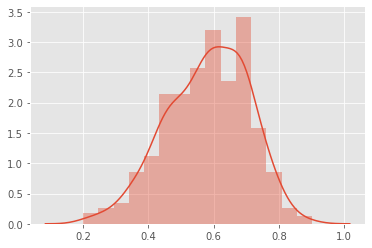

In [92]:
ACC=[]
CLFdiag=None
for run in tqdm(np.arange(500)):
    auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=3,n_estimators=2,
               minsplit=2,VERBOSE=False, USE_ONLY=[2])
    ACC=np.append(ACC,auc)
    if auc > 0.85:
        CLFdiag=CLFS
sns.distplot(ACC)
np.median(ACC)

In [93]:
df=pd.read_csv('PSYCHO.DAT',header=None,index_col=0,sep='\s+')
#df=df[df[1]>0]
df=df[df[1].between(1,2)]

X=df.loc[:,2:].values
#y=df.loc[:,1].values.astype(str)
y=(df.loc[:,1]==1)+0
Xpsy=X

In [94]:
df=pd.read_csv('/home/ishanu/Dropbox/scratch_/Qfeatures.csv')
#df=df[df.labels>0]

df=df[df.labels.between(1,2)]

Xq=df.drop('labels',axis=1).values
#y=df.labels.values.astype(str)
#X=np.c_[Xpsy,Xq]
#X=np.c_[X,Xdiag]
X=np.c_[Xpsy,Xdiag]
#X=X1
#X=np.c_[Xpsy,Xdiag]

In [95]:
y=(df.labels==1)+0

In [96]:
X.shape

(573, 78)

100%|██████████| 2000/2000 [00:10<00:00, 186.14it/s]


{0.7718746779346594: [ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
             criterion='gini', max_depth=3, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=2, n_jobs=None, oob_score=False, random_state=None,
             verbose=0, warm_start=False)],
 0.7507788161993769: [ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
             criterion='gini', max_depth=3, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=2, n_jobs=None, oob_score=False, random_state=None,
             verbose=0, warm_start=False)]}

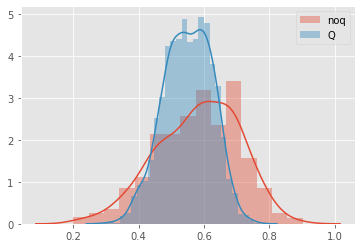

In [97]:
qACC=[]
CLF={}
for run in tqdm(np.arange(2000)):
    auc,CLFS=getAuc(X,y,test_size=0.6,max_depth=3,n_estimators=2,
               minsplit=2,VERBOSE=False, USE_ONLY=[2])
    qACC=np.append(qACC,auc)
    if auc > 0.75:
        CLF[auc]=CLFS
        #print('.')
ax=sns.distplot(ACC,label='noq')
sns.distplot(qACC,ax=ax,label='Q')
ax.legend()
np.median(qACC)
CLF

In [98]:

CLFstar=CLF[np.array([k for k in CLF.keys()]).max()][0]

0.7937751615900652

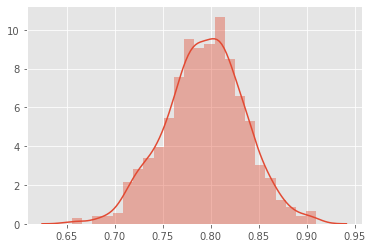

In [102]:
auc_=[]
ROC={}
fpr_ = np.linspace(0, 1, num=20, endpoint=True)
for run in np.arange(1000):
    clf=CLFstar
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    y_pred=clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
    f = interp1d(fpr, tpr)
    auc_=np.append(auc_,metrics.auc(fpr_, f(fpr_)))
    ROC[metrics.auc(fpr, tpr)]={'fpr':fpr_,'tpr':f(fpr_)}
sns.distplot(auc_)
auc_.mean()

0.7947401725442156
0.8246575953928235
0.7799276059241692


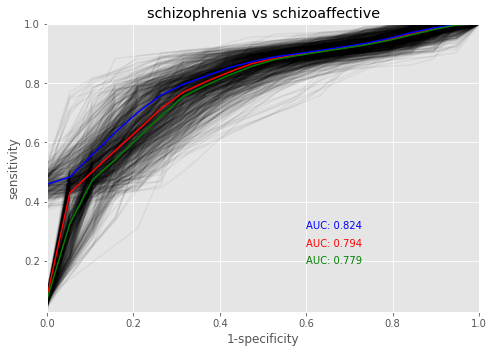

In [130]:
TPR=[]
for a in ROC.keys():
    #print(a)
    #break
    plt.plot(ROC[a]['fpr'],ROC[a]['tpr'],'-k',alpha=.05)
    TPR=np.append(TPR,ROC[a]['tpr'])
TPR=TPR.reshape(int(len(TPR)/len(fpr_)),len(fpr_))
plt.plot(fpr_,np.median(TPR,axis=0),'-r')
tmpf=pd.DataFrame(TPR)
tprA=tmpf[tmpf[0]>.4].values
tprB=tmpf[tmpf[0]<.4].values
plt.plot(fpr_,np.median(tprA,axis=0),'-b')
plt.plot(fpr_,np.median(tprB,axis=0),'-g')

print(metrics.auc(fpr_,np.median(TPR,axis=0)))
print(metrics.auc(fpr_,np.median(tprA,axis=0)))
print(metrics.auc(fpr_,np.median(tprB,axis=0)))
plt.gca().set_title('schizophrenia vs schizoaffective')
plt.text(.6,.25,'AUC: '+str(metrics.auc(fpr_,np.median(TPR,axis=0)))[:5],color='r')
plt.text(.6,.31,'AUC: '+str(metrics.auc(fpr_,np.median(tprA,axis=0)))[:5],color='b')
plt.text(.6,.19,'AUC: '+str(metrics.auc(fpr_,np.median(tprB,axis=0)))[:5],color='g')
plt.gca().set_xlabel('1-specificity')
plt.gca().set_ylabel('sensitivity')
saveFIG('sczVscaff.pdf',AXIS=True)

In [27]:
def pickleModel(models,threshold=0.87,filename='model.pkl',verbose=True):
    '''
        save trained model set
    '''
    MODELS=[]
    for key,mds in models.items():
        if key >= threshold:
            mds_=mds
            MODELS.extend(mds_)
    if verbose:
        print("number of models (tests):", len(MODELS))
        FS=getCoverage(MODELS,verbose=True)
        print("Item Use Fraction:", FS.size/(len(MODELS)+0.0))
    dump(MODELS, filename)
    return MODELS

def loadModel(filename):
    '''
        load models
    '''
    return load(filename)

def drawTrees(model):
    '''
        draw the estimators (trees)
        in a single model
    '''
    N=len(model.estimators_)

    for count in range(N):
        estimator = model.estimators_[count]

        export_graphviz(estimator, out_file='PSYtree.dot', 
                        #feature_names = iris.feature_names,
                        #class_names = iris.target_names,
                        rounded = True, proportion = False, 
                        precision = 2, filled = True)

        from subprocess import call
        call(['dot', '-Tpng', 'PSYtree.dot', '-o', 'PSYtree'+str(count)+'.png', '-Gdpi=600'])
        from IPython.display import Image
        Image(filename = 'PSYtree'+str(count)+'.png') 
        
def getCoverage(model,verbose=True):
    '''
        return how many distinct items (questions)
        are used in the model set.
        This includes the set of questions being
        covered by all forms that may be 
        generated by the model set
    '''
    FS=[]
    for m in model:
        for count in range(len(m.estimators_)):
            clf=m.estimators_[count]
            fs=clf.tree_.feature[clf.tree_.feature>0]
            FS=np.array(list(set(np.append(FS,fs))))
    if verbose:
        print("Number of items used: ", FS.size)
    return FS

In [28]:
models=pickleModel(CLF,threshold=.81,filename='PSYmodel_3_2.pkl',verbose=True)

number of models (tests): 9
Number of items used:  52
Item Use Fraction: 5.777777777777778


In [29]:
models

[ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2, n_jobs=None, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2, n_jobs=None, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_le

In [31]:
drawTrees(models[3])